In [1]:
%cd ..

/home/jairo/Documentos/GitHub/kink-antikink-parellel


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from celluloid import Camera
from multiprocessing import Pool, Lock
from os import cpu_count
from dataclasses import dataclass
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from time import time
from pathlib import Path

from modules.differences import Diff

In [3]:
import matplotlib as mpl

def new_colormap(colors, N=256):
    n = len(colors)
    d = int(N/n)
    cmap = np.zeros((d*n, 4))
    for i in range(n-1):
        for j in range(4):
            cmap[i*d:(i+1)*d, j] = np.linspace(colors[i][j], colors[i+1][j], d)
    return ListedColormap(cmap/255, N=N)

fred_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    name='fred', 
    colors=np.stack([
        (255, 255, 255, 255),
        (69, 129, 255, 255),
        (0, 0, 0, 255),
        (255, 255, 3, 255),
        (255, 109, 3, 255)
    ])/255
)
mpl.colormaps.register(fred_cmap)
plt.rcParams['image.cmap'] = 'fred'

In [10]:
def coefficients_matrix(N: int):
    M = np.zeros((N-2, N))
    for i in range(1, N-3):
        M[i, i-1:i+4] = (-1/12, 4/3, -5/2, 4/3, -1/12)
    M[0, :3] = M[-1, -3:] = (1, -2, 1)
    return M

class Grid:
    def __init__(self, xl, xr, dx=None, N=None):
        assert (dx != None or N != None)
        self.xl, self.xr = xl, xr
        if dx != None:
            self.dx = dx
            self.N = int((xr - xl)/dx)
        elif N != None:
            self.dx = (xr - xl)/N
            self.N = N
        self.x = np.arange(self.xl, self.xr, self.dx)
    
    def window(self, left=None, right=None):
        if left == None: left = self.xl
        if right == None: right = self.xr
        return (self.x >= left) & (self.x <= right)
    
    def at(self, x):
        return np.abs(self.x - x).argmin()

class HyperProblem:
    def __init__(self, grid, h, f, g):
        self.grid = grid
        self.h = h
        self.y0 = np.stack((
            f(grid.x),
            g(grid.x)
        ))
        self.diff = Diff(2, self.grid.N, 5, self.grid.dx)

        # M = coefficients_matrix(grid.N)/grid.dx**2
        # self.M = M[:, 1:-1]
        # self.M0 = np.zeros(grid.N - 2)
        # self.M0[:2] = M[:2, 0]*f(grid.xl)
        # self.M0[-2:] = M[-2:, -1]*f(grid.xr)
        
    def d2y_dx2(self, t, y):
        return self.diff(y) + self.h(self.grid.x, t, y)

    def F(self, t, Y):
        y, dy_dt = Y
        return np.stack((dy_dt, self.d2y_dx2(t, y)))

class RKSolver:
    def __init__(self, hyper_problem, t0, dt):
        self.dt = dt
        self.F = hyper_problem.F
        self._y = [hyper_problem.y0]
        self._t = [t0]

    def step(self):
        t = self._t[-1]
        y = self._y[-1]
        dt = self.dt

        k1 = self.F(t, y)
        k2 = self.F(t + dt/2, y + k1*dt/2)
        k3 = self.F(t + dt/2, y + k2*dt/2)
        k4 = self.F(t + dt, y + k3*dt)

        self._y.append(
            y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
        )
        self._t.append(t + dt)

    def run_util(self, T):
        while self._t[-1] < T:
            self.step()

    @property
    def y(self):
        return np.stack(self._y)

    @property
    def t(self):
        return np.stack(self._t)

@dataclass
class Kink:
    x0: float
    v: float
    lamb: float

    def __post_init__(self):
        gamma = 1/(1 - self.v**2)**0.5
        delta = (2/self.lamb)**0.5
        self._c = gamma/delta

    def z(self, x, t):
        return self._c*(x - self.x0 - self.v*t)
    
    def __call__(self, x, t):
        return np.tanh(self.z(x, t))
    
    def dt(self, x, t):
        return -self._c*self.v/np.cosh(self.z(x, t))**2

class KinkAntikink(RKSolver):
    def __init__(self, grid, x0, v, lamb, dt, t0=0):
        self.lamb = lamb
        self._k1 = Kink(-x0, v, lamb)
        self._k2 = Kink(x0, -v, lamb)
        hyper_problem = HyperProblem(grid, self.h, self.f, self.g)
        self._yl, self._yr = hyper_problem.y0[0, 0], hyper_problem.y0[0, -1]
        super().__init__(hyper_problem, t0, dt)
    
    def f(self, x):
        return self._k1(x=x, t=0) - self._k2(x=x, t=0) - 1
    
    def g(self, x):
        return self._k1.dt(x=x, t=0) - self._k2.dt(x=x, t=0)
    
    def h(self, x, t, y):
        return self.lamb*y*(1 - y**2)
    
    @property
    def y(self):
        return np.stack(self._y)[:, 0]

In [11]:
L = 40
grid = Grid(-L, L, N=1000)

In [18]:
%%time
v = 0.2
x0 = 5
lamb = 2
sol = KinkAntikink(grid, x0, v, lamb, grid.dx*0.7)
sol.run_util(x0/v + grid.xr)

CPU times: user 2.79 s, sys: 3.4 s, total: 6.19 s
Wall time: 904 ms


/tmp/ipykernel_6369/1841340699.py:9: RuntimeWarning: All-NaN slice encountered
  K1 = np.nanmax(X, axis=1)
/tmp/ipykernel_6369/1841340699.py:10: RuntimeWarning: All-NaN slice encountered
  K2 = np.nanmin(X, axis=1)


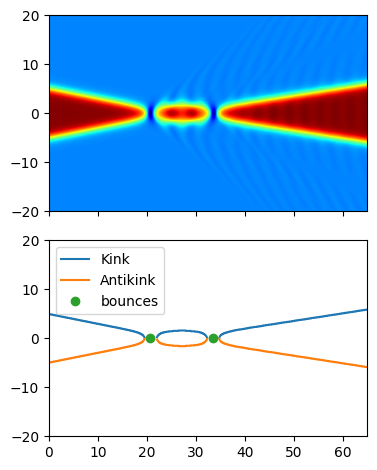

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)

w = grid.window(-20, 20)
ax1.imshow(sol.y[:, w].T, extent=(sol.t[0], sol.t[-1], -20, 20), aspect='equal', origin='lower', cmap='jet')

X, _ = np.meshgrid(grid.x[w], sol.t)
X = np.where(sol.y[:, w] > 0, X, np.nan)
K1 = np.nanmax(X, axis=1)
K2 = np.nanmin(X, axis=1)

y = sol.y[:, grid.at(0)]**2
peaks, _ = find_peaks(y, prominence=1.5)
bounces = np.argsort(y[peaks])

ax2.plot(sol.t, K1, label='Kink')
ax2.plot(sol.t, K2, label='Antikink')
ax2.plot(sol.t[peaks][bounces], np.zeros(bounces.shape), 'o', label='bounces')
ax2.set_aspect('equal')
ax2.set_ylim(-20, 20)
ax2.legend()

fig.tight_layout()
plt.show()

In [24]:
X*loc

array([[-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       ...,
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [-0., -0., -0., ...,  0.,  0.,  0.]])

ValueError: x and y must have same first dimension, but have shapes (1162,) and (500,)

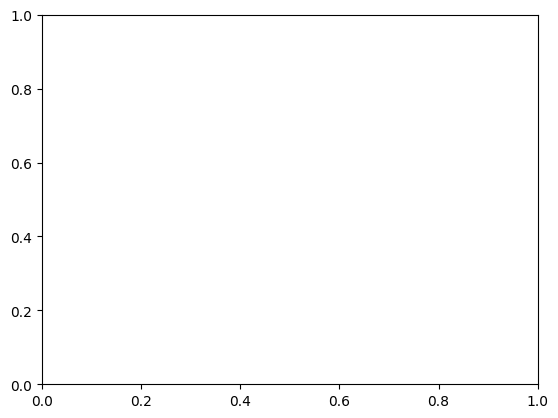

In [30]:
X, _ = np.meshgrid(grid.x[w], sol.t)
loc = sol.y[:, w] > 0
k1, k2 = [], []
for i in range(loc.shape[1]):
    ux = X[:, i]*loc[:, i]
    k1.append(ux.max())
    k2.append(ux.min())
plt.plot(sol.t, k1, sol.t, k2)

0.1544640179407925


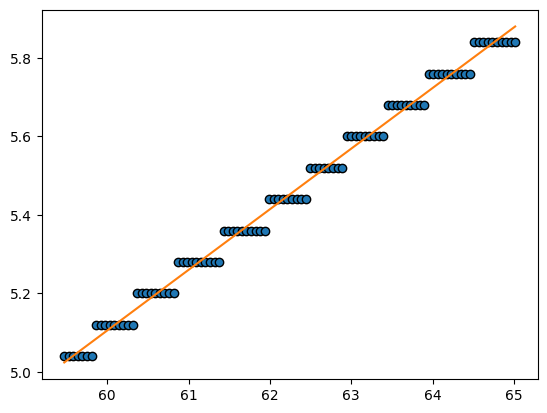

In [45]:
t, x = sol.t[-100:], K1[-100:]
(a, b), _ = curve_fit(lambda t, a, b: a*t + b, t, x)
plt.plot(t, x, 'o', markeredgecolor='k')
plt.plot(t, a*t + b)
print(a)

-0.20104191633147964


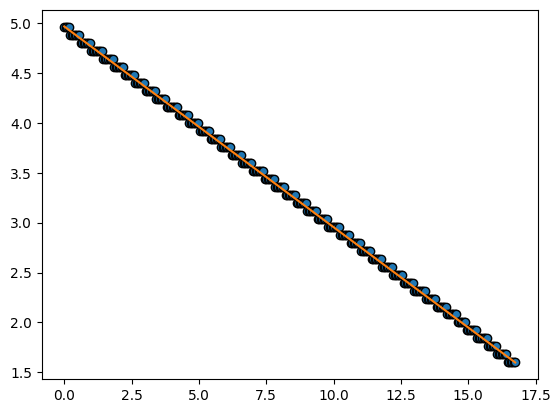

In [49]:
t, x = sol.t[:300], K1[:300]
(a, b), _ = curve_fit(lambda t, a, b: a*t + b, t, x)
plt.plot(t, x, 'o', markeredgecolor='k')
plt.plot(t, a*t + b)
print(a)

In [100]:
/%%time
v = 0.2
x0 = 5
lamb = 15
sol = KinkAntikink(grid, x0, v, lamb, grid.dx*0.7)
sol.run_util(x0/v + grid.xr)

CPU times: user 18.4 s, sys: 27.6 s, total: 46.1 s
Wall time: 6.24 s


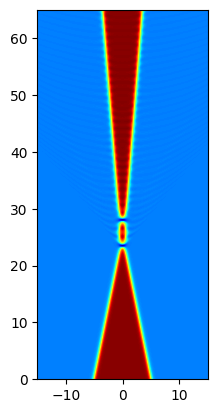

In [31]:
r, l = -15, 15
plt.imshow(sol.y[:, grid.window(r, l)], extent=(r, l, sol.t[0], sol.t[-1]), aspect='equal', origin='lower', cmap='jet')

In [ ]:
path = Path('../data/dataset/')
V = np.arange(0.1, 0.3, (0.3-0.1)/1000)
x0 = 5
lamb = 2

linear = lambda t, a, b: a*t + b
lock = Lock()
def collide(v):
    filename = path/f'lamb:{lamb}-v:{v}.csv'
    if not filename.exists():
        sol = KinkAntikink(grid, x0, v, lamb, grid.dx*0.7)
        sol.run_util(x0/v + grid.xr)
        pd.DataFrame(sol.y.T, columns=sol.t, index=grid.x).to_csv(filename)
        with lock:
            print(len(list(path.glob('*')))*100/1000)

with Pool(processes=cpu_count()-1) as pool:
    pool.map(collide, V)

25.5
25.6
25.8
25.8
25.8
25.9
25.9
26.1
26.1
26.3
26.5
26.6
26.6
26.7
26.7
26.8
26.9
27.1
27.1
27.5
27.5
27.5
27.5
27.7
27.8
28.2
28.2
28.2
28.2
28.2
28.4
28.5
28.8
28.9
28.9
28.9
28.9
29.1
29.1
29.3
29.3
29.6
29.6
29.6
30.1
30.1
30.2
30.2
30.3
30.3
30.3
30.5
30.9
30.9
30.9
31.0
31.0
31.0
31.2
31.2
31.5
31.7
31.7
31.7
31.7
31.8
31.9
32.2
32.2
32.4
32.5
32.5
32.5
32.8
32.8
32.9
32.9
33.1
33.1
33.2
33.5
33.5
33.6
33.6
33.8
34.0
34.1
34.2
34.2
34.2
34.4
34.6
34.6
34.7
34.8
34.8
35.1
35.1
35.2
35.3
35.4
35.4
35.5
35.6
35.9
36.1
36.1
36.2
36.2
36.2
36.3
36.7
36.7
36.8
36.8
36.9
37.0
37.0
37.1
37.5
37.5
37.6
37.6
37.6
37.8
37.8
38.0
38.1
38.3
38.3
38.3
38.4
38.5
38.8
39.0
39.0
39.1
39.1
39.1
39.2
39.4
39.6
39.6
39.6
39.8
39.8
39.9
40.1
40.3
40.3
40.4
40.4
40.7
40.8
40.8
40.8
40.9
41.1
41.1
41.3
41.3
41.6
41.8
41.8
41.8
41.8
41.9
42.2
42.2
42.4
42.5
42.5
42.6
42.6
42.8
42.8
43.2
43.2
43.2
43.3
43.3
43.5
43.6
43.7
43.9
43.9
44.0
44.1
44.2
44.3
44.3
44.4
44.8
45.0
45.0
45.0
45.0
45.0
45.1
45.5


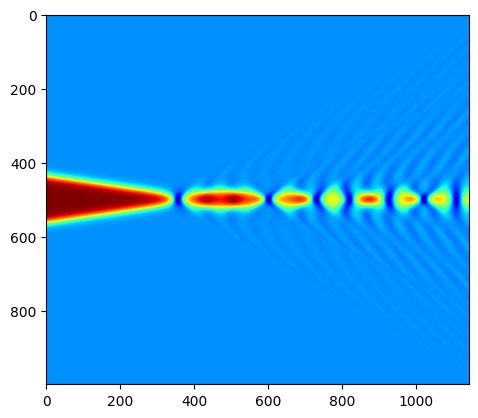

In [ ]:
files = tuple(path.glob('*'))
plt.imshow(pd.read_csv(files[0], index_col=0).values, cmap='jet')

In [ ]:
linear = lambda t, a, b: a*t + b
v_in, N_bounces = [], []
for i, file in enumerate(files):
    v_in.append(float(file.stem.split('-')[1].split(':')[1]))
    sol = pd.read_csv(file, index_col=0)
    y = sol.values[grid.at(0)]**2
    t = sol.columns.values.astype(float)
    x = sol.index.values.astype(float)
    peaks, _ = find_peaks(y, prominence=1.5)
    N_bounces.append(len(y[peaks]))
N_bounces = np.stack(N_bounces)[np.argsort(v_in)]
v_in = np.sort(v_in)

In [ ]:
N_bounces = np.stack(N_bounces)[np.argsort(v_in)]
v_in = np.sort(v_in)

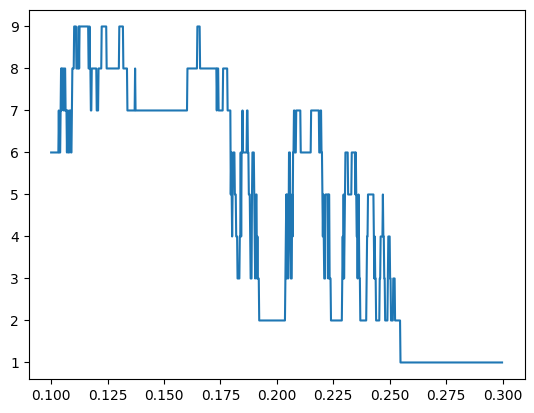

In [ ]:
plt.plot(v_in, N_bounces, '-')

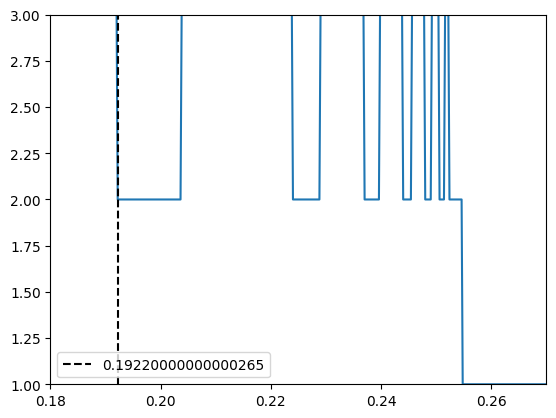

In [ ]:
plt.plot(v_in, N_bounces, '-')
plt.ylim(1, 3)
plt.xlim(0.18, 0.27)
v2_min = v_in[N_bounces == 2].min()
plt.vlines(v2_min, 1, 3, colors='k', linestyles='dashed', label=v2_min)
plt.legend()
plt.show()

(0.18, 0.27)

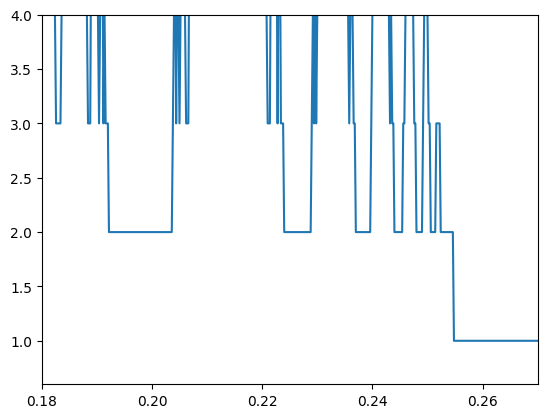

In [ ]:
plt.plot(v_in, N_bounces, '-')
plt.ylim(top=4)
plt.xlim(0.18, 0.27)

$$
2x_0 \gg \delta = \sqrt{2/\lambda}
$$

$$
4x_0^2 \gg 2/\lambda
$$

$$
\lambda \gg \frac{1}{2x_0^2} = \frac{1}{2(5)^2} = \frac{1}{50} = 0.02
$$

In [120]:
pd.DataFrame(solver.Y[:, 0], columns=grid.x[1:-1], index=solver.t)

,-39.92,-39.84,-39.76,-39.68,-39.60,-39.52,-39.44,-39.36,-39.28,-39.20,...,39.12,39.20,39.28,39.36,39.44,39.52,39.60,39.68,39.76,39.84
0.000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.056,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.112,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.168,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0.224,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64.792,-0.999979,-0.999965,-0.999963,-0.999971,-0.999986,-1.000004,-1.000017,-1.000026,-1.000028,-1.000025,...,-1.000042,-1.000040,-1.000025,-1.000003,-0.999984,-0.999973,-0.999973,-0.999980,-0.999989,-0.999996
64.848,-0.999997,-0.999991,-0.999983,-0.999976,-0.999975,-0.999985,-1.000002,-1.000023,-1.000037,-1.000039,...,-1.000039,-1.000034,-1.000014,-0.999990,-0.999974,-0.999974,-0.999987,-1.000004,-1.000015,-1.000012
64.904,-1.000015,-1.000019,-1.000009,-0.999991,-0.999977,-0.999975,-0.999988,-1.000010,-1.000029,-1.000034,...,-1.000016,-1.000011,-0.999997,-0.999983,-0.999979,-0.999988,-1.000007,-1.000024,-1.000030,-1.000021
64.960,-1.000023,-1.000034,-1.000029,-1.000011,-0.999991,-0.999979,-0.999981,-0.999993,-1.000006,-1.000011,...,-0.999982,-0.999980,-0.999981,-0.999986,-0.999997,-1.000011,-1.000024,-1.000031,-1.000029,-1.000017


In [5]:
from pathlib import Path
import pandas as pd
data_dir = Path('../data/mosaico')

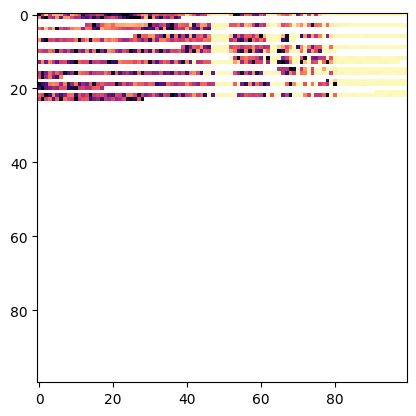

In [43]:
plt.imshow(pd.read_csv(data_dir/'mosaic.csv', index_col=0).values)

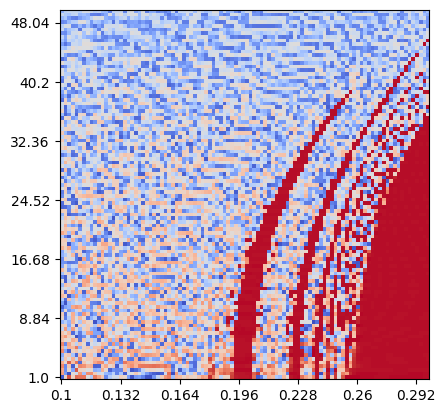

In [31]:
cm = pd.read_csv(data_dir/'mosaic.csv', index_col=0)
plt.imshow(cm.values, cmap='coolwarm', origin='lower')
plt.xticks(np.arange(0, cm.columns.size, cm.columns.size//6), cm.columns[::cm.columns.size//6].values.astype(float))
plt.yticks(np.arange(0, cm.index.size, cm.index.size//6), cm.index[::cm.index.size//6].values.astype(float))
plt.show()

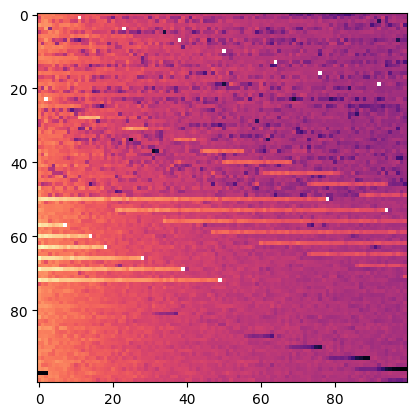

In [27]:
ex_time = pd.read_csv(data_dir/'exec_time.csv', index_col=0).values
plt.imshow(np.where(ex_time > np.nanmax(ex_time)*0.1, np.nan, ex_time))

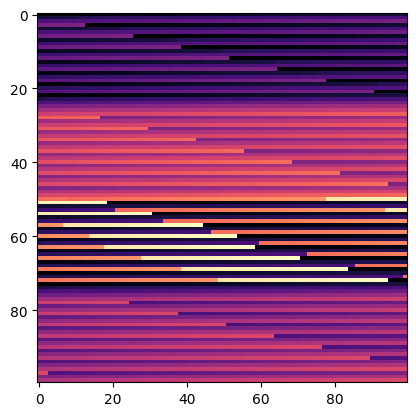

In [28]:
plt.imshow(pd.read_csv(data_dir/'ell_time.csv', index_col=0).values)

In [18]:
cm = pd.read_csv(data_dir/'mosaic.csv', index_col=0)
1 - cm.isnull().values.sum()/cm.size

0.9696

In [1]:
import sympy as sp

In [3]:
from sympy.abc import x
A0, lamb, delta = sp.symbols(r'A_0, \lambda, \delta')
X0 = A0*sp.exp(lamb*x)*sp.cosh(x/delta)**(sp.sqrt(6)/delta)
X0

A_0*exp(\lambda*x)*cosh(x/\delta)**(sqrt(6)/\delta)

In [4]:
V = sp.sqrt(6)*sp.tanh(x/delta)/delta
V

sqrt(6)*tanh(x/\delta)/\delta

In [6]:
-X0.diff(x, 2) + V**2*X0

-A_0*(\lambda**2 + 2*sqrt(6)*\lambda*sinh(x/\delta)/(\delta**2*cosh(x/\delta)) + (-sqrt(6)*sinh(x/\delta)**2/cosh(x/\delta)**2 + sqrt(6) + 6*sinh(x/\delta)**2/(\delta*cosh(x/\delta)**2))/\delta**3)*exp(\lambda*x)*cosh(x/\delta)**(sqrt(6)/\delta) + 6*A_0*exp(\lambda*x)*cosh(x/\delta)**(sqrt(6)/\delta)*tanh(x/\delta)**2/\delta**2